# Infill with MM's infilling method and SR1.5

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import os

import silicone.database_crunchers
from silicone.time_projectors import ExtendLatestTimeQuantile
import scmdata
import scmdata.database
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm.autonotebook import tqdm

from ndcs.infilling import (
    extend_timeseries,
    calc_ghg,
    kyoto_ghg_exclude_co2_vars,
    TimeDepRatio,
    EqualQuantileWalk_MM,
)  # This is for a bugfix
from ndcs.constants import (
    PROCESSED_DATA_DIR,
    NDC_TARGET_RELEASE,
    RAW_DATA_DIR,
    LEAD,
    CONTEXT,
)

<IPython.core.display.Javascript object>

/home/jared/miniconda3/envs/ndc-realisations-2021/lib/python3.9/site-packages/scmdata/database.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

In [5]:
GLOBAL_DATABASE_DIR = os.path.join(
    PROCESSED_DATA_DIR, "global_emissions_pathways", NDC_TARGET_RELEASE
)

<IPython.core.display.Javascript object>

In [6]:
global_db = scmdata.database.ScmDatabase(
    GLOBAL_DATABASE_DIR,
    levels=(
        "ambition",
        "conditionality",
        "country_extension",
        "exclude_hot_air",
        "pathway_id",
        "global_extension",
    ),
)
global_db

<scmdata.database.SCMDatabase (root_dir: /home/jared/code/cr/ndc-realisations-2021/src/ndcs/../../data/processed/global_emissions_pathways/12Nov2021a_CR, levels: ('ambition', 'conditionality', 'country_extension', 'exclude_hot_air', 'pathway_id', 'global_extension'))>

<IPython.core.display.Javascript object>

In [7]:
extended_scenario_all = scmdata.ScmRun(
    os.path.join(
        PROCESSED_DATA_DIR,
        "global_emissions_pathways",
        NDC_TARGET_RELEASE,
        "emissions_ghg_extended.csv",
    )
).drop_meta("global_extension")

<IPython.core.display.Javascript object>

In [8]:
extended_scenario_sample = extended_scenario_all.filter(
    scenario=extended_scenario_all.get_unique_meta("scenario")[0]
)
extended_scenario_sample

<ScmRun (timeseries: 1, timepoints: 86)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	  ambition conditionality country_extension        date exclude_hot_air last_country          model    pathway_id  pathway_num  pathway_num_today region                                scenario     stage         unit  \
	0     high              C            SSP1BL  2021-08-02         exclude          COG  NDC Factsheet  2021-08-02_1          309                  1  World  2021-08-02_1__high__C__SSP1BL__exclude  extended  Mt CO2 / yr   
	
	                                   variable  
	0  Emissions|GHG excl CO2 AFOLU (AR6GWP100)  

<IPython.core.display.Javascript object>

In [9]:
extended_scenario_sample.timeseries()

,,,,,,,,,,,,,,time,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,...,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
ambition,conditionality,country_extension,date,exclude_hot_air,last_country,model,pathway_id,pathway_num,pathway_num_today,region,scenario,stage,unit,variable,,,,,,,,,,,,,,,
high,C,SSP1BL,2021-08-02,exclude,COG,NDC Factsheet,2021-08-02_1,309,1,World,2021-08-02_1__high__C__SSP1BL__exclude,extended,Mt CO2 / yr,Emissions|GHG excl CO2 AFOLU (AR6GWP100),50801.212705,50904.230828,51561.060711,52365.200699,52682.002397,52672.554015,52708.680202,...,20901.772498,20682.016819,20513.546555,20344.614729,20176.144466,20007.674202,19839.203938


<IPython.core.display.Javascript object>

In [10]:
sr15_data_cleaned = scmdata.ScmRun(os.path.join(PROCESSED_DATA_DIR, "sr15_data.csv"))

<IPython.core.display.Javascript object>

In [11]:
sr15_data_cleaned

<ScmRun (timeseries: 10686, timepoints: 86)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      climate_model                                       id              model region                scenario       stage todo         unit                                  variable
	0       unspecified           AIM_2_0_ADVANCE_2020_1.5C-2100            AIM_2_0  World  ADVANCE_2020_1.5C-2100  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	1       unspecified               AIM_2_0_ADVANCE_2020_Med2C            AIM_2_0  World      ADVANCE_2020_Med2C  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	2       unspecified                AIM_2_0_ADVANCE_2020_WB2C            AIM_2_0  World       ADVANCE_2020_WB2C  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	3       unspecified               AIM_2_0_ADVANCE_2030_Med2C            AIM_2_0  World      ADVANCE_2030_Med2C  harmonised  SET  Mt CO2 / yr  Emissions|

<IPython.core.display.Javascript object>

In [12]:
def calc_cum_emis(emis, zero_year=2020):
    cum_emissions = emis.integrate().relative_to_ref_period_mean(year=zero_year)

    return cum_emissions.convert_unit("Gt CO2")

<IPython.core.display.Javascript object>

In [13]:
def generate_percentage_differences(inp):
    df = inp.filter(year=2100).timeseries()
    
    df_2 = df.unstack("stage").sort_index()
    df_2.index = df_2.index.droplevel(
        level=list(set(df_2.index.names) - {"scenario", "stage"})
    )
    df_2.columns = df_2.columns.get_level_values("stage")
    
    df_pct_change = df_2.pct_change(axis=1).iloc[:, -1]
    df_pct_change.name = "pct_change"
    return df_pct_change


<IPython.core.display.Javascript object>

# Check how well infilling should work

In [14]:
median_sr15 = sr15_data_cleaned.quantiles_over(
    ("id", "model", "scenario"), [0.1, 0.25, 0.5, 0.75, 0.9]
)
median_sr15["scenario"] = "SR15 median"
median_sr15["model"] = "not_applicable"
median_sr15 = scmdata.ScmRun(median_sr15)
median_sr15["scenario"] = ["SR15 median " + str(q) for q in median_sr15["quantile"]]
median_sr15

<ScmRun (timeseries: 130, timepoints: 86)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	    climate_model           model  quantile region         scenario       stage todo                unit                                    variable
	0     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET          Mt BC / yr                                Emissions|BC
	1     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET        kt C2F6 / yr                              Emissions|C2F6
	2     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET       kt C6F14 / yr                             Emissions|C6F14
	3     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET         kt CF4 / yr                               Emissions|CF4
	4     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET         Mt CH4 / yr                               Emiss

<IPython.core.display.Javascript object>

In [15]:
median_sr15_ghg = calc_ghg(median_sr15, kyoto_ghg_exclude_co2_vars)
median_sr15_ghg["stage"] = "single"

<IPython.core.display.Javascript object>

In [16]:
data_of_interest = scmdata.run_append(
    [
        median_sr15_ghg,
        median_sr15.filter(variable="Emissions|GHG excl CO2 AFOLU (AR6GWP100)"),
    ]
)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2 / yr'>

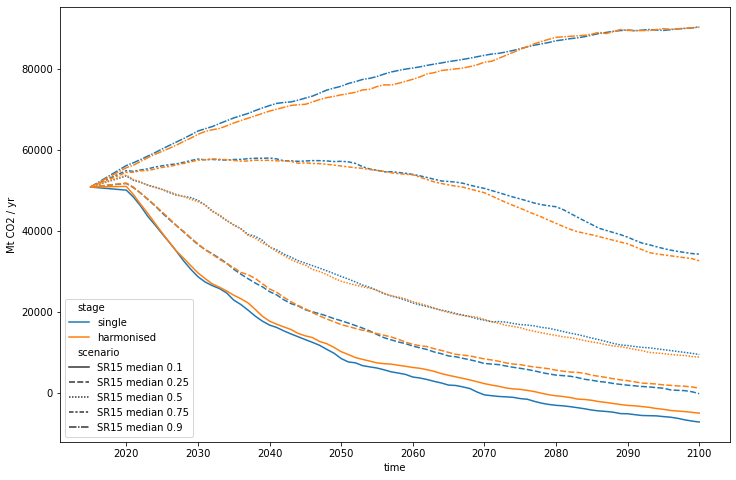

<IPython.core.display.Javascript object>

In [17]:
data_of_interest.lineplot(hue="stage", style="scenario")

In [18]:
generate_percentage_differences(calc_cum_emis(data_of_interest))

scenario
SR15 median 0.1    -0.156276
SR15 median 0.25   -0.032854
SR15 median 0.5     0.017501
SR15 median 0.75    0.022740
SR15 median 0.9     0.013075
Name: pct_change, dtype: float64

<IPython.core.display.Javascript object>

# Infill other gases
We now have a scenario extended to 2100, now we need to split the GHG emissions into individual species

In [73]:
magicc_required_variables = [
    "Emissions|BC",
    "Emissions|C2F6",
    "Emissions|C6F14",
    "Emissions|CF4",
    "Emissions|CH4",
    "Emissions|CO",
#     "Emissions|CO2|MAGICC AFOLU",
    "Emissions|CO2|MAGICC Fossil and Industrial",
    "Emissions|HFC125",
    "Emissions|HFC134a",
    "Emissions|HFC143a",
    "Emissions|HFC227ea",
    "Emissions|HFC23",
    "Emissions|HFC245fa",
    "Emissions|HFC32",
    "Emissions|HFC4310",
    "Emissions|N2O",
    "Emissions|NH3",
    "Emissions|NMVOC",
    "Emissions|NOx",
    "Emissions|OC",
    "Emissions|SF6",
    "Emissions|SOx",
]


<IPython.core.display.Javascript object>

In [74]:
YEARS_TO_INFILL = [2015] + list(range(2020, 2100 + 1, 5))
YEARS_TO_INFILL

[2015,
 2020,
 2025,
 2030,
 2035,
 2040,
 2045,
 2050,
 2055,
 2060,
 2065,
 2070,
 2075,
 2080,
 2085,
 2090,
 2095,
 2100]

<IPython.core.display.Javascript object>

In [75]:
infilling_database = sr15_data_cleaned.filter(year=YEARS_TO_INFILL).to_iamdataframe()
infilling_database.dimensions

['model',
 'scenario',
 'region',
 'variable',
 'unit',
 'time',
 'climate_model',
 'id',
 'stage',
 'todo']

<IPython.core.display.Javascript object>

In [ ]:
def infill_scenarios(scenario):
    infilling_database = (
        sr15_data_cleaned.filter(year=YEARS_TO_INFILL)
        .drop_meta(["climate_model", "id", "todo"])
        .copy()
        .to_iamdataframe()
    )
    infilled_scenario = scenario.filter(year=YEARS_TO_INFILL).copy().to_iamdataframe()

    cruncher = EqualQuantileWalk_MM(
        infilling_database, bottom_up_gases=kyoto_ghg_exclude_co2_vars
    )
    for variable in tqdm(magicc_required_variables, desc="Variable", leave=False):
        infiller = cruncher.derive_relationship(variable, [LEAD])

        infilled = scmdata.ScmRun(infiller(infilled_scenario)).copy().to_iamdataframe()
        infilled_scenario.append(infilled, inplace=True)
    return scmdata.ScmRun(infilled_scenario)


infilled_scenario = infill_scenarios(extended_scenario_sample)

Variable:   0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
infilled_scenario.get_unique_meta("variable")

# Check the infilling

In [ ]:
infilled_scenario.filter(
    variable="Emissions|GHG excl CO2 AFOLU (AR6GWP100)"
).timeseries()

In [ ]:
infilled_scenario_ghg = calc_ghg(
    infilled_scenario, include_vars=kyoto_ghg_exclude_co2_vars, context=CONTEXT
)
infilled_scenario_ghg["stage"] = "infilled"

In [ ]:
plt.title("Emissions|GHG excl CO2 AFOLU (AR6GWP100)")
scmdata.run_append(
    [
        infilled_scenario.filter(variable=LEAD),
        infilled_scenario_ghg,
    ]
).lineplot(hue="scenario", style="stage")

In [ ]:
cum_ghg_emis = calc_cum_emis(
    scmdata.run_append(
        [
            infilled_scenario.filter(variable=LEAD),
            infilled_scenario_ghg,
        ]
    )
    .filter(year=range(2020, 2101))
    .resample("AS")
)

In [ ]:
generate_percentage_differences(cum_ghg_emis)

In [ ]:
infilled_scenario.filter(
    variable="Emissions|GHG excl CO2 AFOLU (AR6GWP100)*"
).timeseries()

In [ ]:
infilled_scenarios_all = infill_scenarios(extended_scenario_all)

In [ ]:
infilled_scenarios_ghg_all = calc_ghg(
    infilled_scenarios_all, include_vars=kyoto_ghg_exclude_co2_vars, context=CONTEXT
)
infilled_scenarios_ghg_all["stage"] = "infilled"
cum_ghg_emis_all = calc_cum_emis(
    scmdata.run_append(
        [
            infilled_scenarios_all.filter(variable=LEAD),
            infilled_scenarios_ghg_all,
        ]
    )
    .filter(year=range(2020, 2101))
    .resample("AS")
)
pct_diffs = generate_percentage_differences(cum_ghg_emis_all)
pct_diffs

In [ ]:
pct_diffs.describe()

In [ ]:
for_seaborn = cum_ghg_emis_all.filter(year=2100).timeseries().unstack("stage")
for_seaborn.columns = for_seaborn.columns.get_level_values("stage")
for_seaborn.index = for_seaborn.index.get_level_values("scenario")

for_seaborn = pd.merge(for_seaborn, pct_diffs, left_index=True, right_index=True)

sns.scatterplot(data=for_seaborn, x="extended", y="pct_change")

In [ ]:
num_plots = len(magicc_required_variables)

fig = plt.figure(figsize=(16, 8 * num_plots))
axs = fig.subplots(num_plots, sharex=True)

for i, v in enumerate(magicc_required_variables[:num_plots]):
    ax = axs[i]
    pkwargs = {
        "hue": None,
        "color": "0.7",
        "lw": 0.6,
        "alpha": 0.4,
        "units": "id",
        "estimator": None,
        "legend": False,
    }

    sr15_data_cleaned.filter(year=YEARS_TO_INFILL, variable=v).lineplot(
        ax=ax, **pkwargs
    )
    infilled_scenarios_all.filter(
        variable=v, exclude_hot_air="exclude", pathway_id="2021-11-09_1"
    ).lineplot(
        ax=ax,
        legend=False,
        style="country_extension",
        units="scenario",
        estimator=None,
    )
    ax.set_title(v)

In [ ]:
infilled_scenarios_all.head()

## Add AFOLU

In [ ]:
AFOLU_SELECTED_SCENARIO = "Adjusted NDCs FOLU (SSP1-1.9)"

In [ ]:
afolu = scmdata.ScmRun(
    os.path.join(
        PROCESSED_DATA_DIR, "global_emissions", NDC_TARGET_RELEASE, "landuse.csv"
    )
).convert_unit("Mt CO2 / yr")
afolu

In [ ]:
afolu.lineplot(hue="scenario")

In [ ]:
selected_afolu = afolu.filter(
    scenario=AFOLU_SELECTED_SCENARIO, year=range(2000, 2101)
).convert_unit("Mt CO2 / yr")
selected_afolu["variable"] = "Emission|CO2|MAGICC AFOLU"
selected_afolu

In [ ]:
sr15_afolu = sr15_data_cleaned.filter(
    variable="Emissions|CO2|MAGICC AFOLU"
).convert_unit("Mt CO2 / yr")

In [ ]:
extended_afolu = extend_timeseries(
    sr15_afolu, selected_afolu, lead="Emissions|CO2|MAGICC AFOLU"
)
extended_afolu

In [ ]:
pkwargs = {
    "hue": None,
    "color": "0.7",
    "lw": 0.6,
    "alpha": 0.4,
    "units": "id",
    "estimator": None,
    "legend": False,
}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)

sr15_afolu.lineplot(ax=ax, **pkwargs)
extended_afolu.lineplot(ax=ax, linestyle="--", dashes=(10, 15), label="To infill")
selected_afolu.lineplot(ax=ax, label="Original")
ax.set_title("Database CO$_2$|AFOLU and lead emissions timeseries")

In [ ]:
def add_afolu(scenario):
    infilled_scenario_complete = (
        scenario.append(extended_afolu).filter(year=range(2000, 2101)).resample("AS")
    )
    infilled_scenario_complete["global_extension"] = "eqw"
    infilled_scenario_complete["ambition"] = scenario.get_unique_meta("ambition")
    infilled_scenario_complete["conditionality"] = scenario.get_unique_meta(
        "conditionality"
    )
    infilled_scenario_complete["exclude_hot_air"] = scenario.get_unique_meta(
        "exclude_hot_air"
    )
    infilled_scenario_complete["country_extension"] = scenario.get_unique_meta(
        "country_extension"
    )
    infilled_scenario_complete["pathway_id"] = scenario.get_unique_meta("pathway_id")
    infilled_scenario_complete["stage"] = "infilled"

    infilled_scenario_complete["scenario"] = scenario.get_unique_meta("scenario")

    return infilled_scenario_complete

In [ ]:
infilled_scenarios_complete_all = []

for infilled_scenario in tqdm(
    infilled_scenarios_all.groupby(
        [
            "ambition",
            "conditionality",
            "country_extension",
            "exclude_hot_air",
            "pathway_id",
        ]
    )
):
    infilled_scenario_complete = add_afolu(infilled_scenario)
    infilled_scenarios_complete_all.append(infilled_scenario_complete)

infilled_scenarios_complete_all = scmdata.run_append(infilled_scenarios_complete_all)

In [ ]:
infilled_scenario_complete.timeseries()

In [ ]:
infilled_scenarios_complete_all.timeseries()

In [ ]:
infilled_scenarios_complete_all

In [ ]:
global_db.delete(global_extension="eqw")

global_db.save(
    infilled_scenarios_complete_all.drop_meta(
        ["last_country", "pathway_num", "pathway_num_today", "date"]
    )
)

In [ ]:
infilled_scenarios_complete_all.meta[
    ["ambition", "conditionality", "country_extension", "exclude_hot_air"]
].drop_duplicates()

In [ ]:
for c in [
    "ambition",
    "conditionality",
    "country_extension",
    "exclude_hot_air",
    "pathway_id",
]:
    print(infilled_scenarios_complete_all.get_unique_meta(c))

In [50]:
infilled_scenarios_complete_all.meta[["pathway_id"]].drop_duplicates()

,pathway_id
0,2021-11-09_1
48,2013-07-18_1
72,2013-07-18_2
96,2013-07-18_3
120,2015-08-05_1
144,2015-09-26_1
168,2015-09-30_1
192,2015-09-30_2
216,2015-10-01_1
240,2015-10-01_2


<IPython.core.display.Javascript object>